In [90]:
%matplotlib inline

import sqlite3
import pandas as pd #for data frames
import numpy as np #numpy array operations
import nltk #natural lang processing, for processing text
import string
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import pickle
import seaborn as sn

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import BernoulliNB,MultinomialNB

from sklearn.preprocessing import StandardScaler

In [27]:
conn=sqlite3.connect('database.sqlite')
conn.cursor()
conn.commit()
conn.text_factory=str

In [54]:
df=pd.read_sql_query("""SELECT * FROM REVIEWS WHERE Score != 3""",conn)

In [55]:
df.sort_values('Time',axis=0, kind='quicksort', inplace=True)

In [56]:
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...


In [57]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [58]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [59]:
import re
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(df['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, "html.parser").get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 525814/525814 [02:31<00:00, 3466.85it/s]


In [60]:
df['CleanedText'] = preprocessed_reviews

In [61]:
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuice well written movie everything exce...


In [62]:
import pickle

def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"), protocol=4)
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [63]:
df['Score'] = df['Score'].apply(lambda x: 'Positive' if int(x)>3 else 'Negative')

In [65]:
df.sort_values('ProductId',axis=0,ascending=True, inplace=True)

In [66]:
df.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=True)

In [70]:
df.sort_values('Time',axis=0,inplace=True,kind='quicksort')

In [69]:
df["Score"].value_counts()

Positive    307063
Negative     57110
Name: Score, dtype: int64

In [71]:
df_pos=df[df["Score"] == 'Positive'].sample(n=20000)
df_neg=df[df["Score"] == 'Negative'].sample(n=20000)
fin_df=pd.concat([df_pos,df_neg])
fin_df.shape

(40000, 11)

In [73]:
fin_df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
295815,320431,B000E1HVR0,A1BIKTFD3T7KUE,"Water Baby ""wb""",13,13,Positive,1173484800,Unique flavor found in no other sauce. LOVE it!,"I agree with the lady who stated ""This is the ...",agree lady stated spaghetti remember childhood...
153540,166477,B000EZMRRA,A2GQB8ZA3TELU9,Peter Foss,0,0,Positive,1329350400,Best ever,"This is, by far, the best jerky I have ever tr...",far best jerky ever tried hot spicy excellent ...
104927,113909,B000EDK7F6,A3F3B1JPACN215,Michael G. Lustig,13,13,Positive,1266192000,Lecithin and Cayenne,All you you have to do is search the web for L...,search web lecithin cayenne lecithin natural e...


# BOW

In [74]:
X, y = fin_df["CleanedText"], fin_df["Score"]

In [138]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.3)

In [139]:
count_vect=CountVectorizer()
stdscaler=StandardScaler(with_mean=False)
#final_count=count_vect.fit_transform(test_data["CleanedText"].values)
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)
X_train=stdscaler.fit_transform(X_train)
X_test=stdscaler.transform(X_test)
print("the type of count vectorizer is:",type(X_train))
#final_count.get_shape()
print(X_train.shape,X_test.shape)

t:\hari\appliedaicourse\appai\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


the type of count vectorizer is: <class 'scipy.sparse.csr.csr_matrix'>
(28000, 33781) (12000, 33781)


In [140]:
bNB=BernoulliNB()
alpha_list = list(range(1,30,2))
cv_score = []
for i in alpha_list:
    bNB = BernoulliNB(alpha=i)
    scores = cross_val_score(bNB, X_train, Y_train, cv=3, scoring="accuracy")
    cv_score.append(scores.mean())

Optimal alpha:  1
####################################################################################################


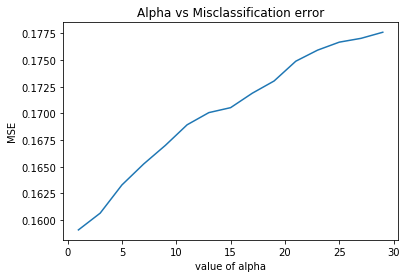

In [141]:
MSE = [1-x for x in cv_score]
optimal_alpha = alpha_list[MSE.index(min(MSE))]
print("Optimal alpha: ",optimal_alpha)
print('#'*100)
import matplotlib.pyplot as plt
plt.plot(alpha_list, MSE)
plt.title("Alpha vs Misclassification error")
plt.xlabel("value of alpha")
plt.ylabel("MSE")
plt.show()

In [142]:
nB_opt=BernoulliNB(alpha=optimal_alpha)
nB_opt.fit(X_train,Y_train)
prediction=nB_opt.predict(X_test)

acc_score=accuracy_score(Y_test,prediction)* 100
print('\n the accuracy score for bag of words model with optimal a=%d is %f%%' % (optimal_alpha,(acc_score)))
print('#'*100)
print("Number of mislabeled points out of a total %d points : %d" % (X_train.shape[0],(Y_test != prediction).sum()))
print('%'*50)


 the accuracy score for bag of words model with optimal a=1 is 84.425000%
####################################################################################################
Number of mislabeled points out of a total 28000 points : 1869
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


In [143]:
training_accuracy = nB_opt.score(X_train, Y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(Y_test, prediction)
test_error = 1 - test_accuracy

print("training error:%.2f%%" %training_error)
print('#'*100)
print("training accuracy:%.2f%%" %training_accuracy)
print('#'*100)
print("test error:%.2f%%" %test_error)
print('#'*100)
print("test accuracy:%.2f%%" %test_accuracy)

training error:0.11%
####################################################################################################
training accuracy:0.89%
####################################################################################################
test error:0.16%
####################################################################################################
test accuracy:0.84%
